## Statistical Techniques for Spatio-Temporal Data Analysis

## Monthly Analysis for the Rainfall Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import seaborn as sns

### Reading the file

In [2]:
df = pd.read_csv("Sub_Division_IMD_2017.csv")

### Collected Data for Andaman 

In [3]:
new_df = df.loc[:111,['YEAR',"JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]].copy()

### Giving column names

In [4]:
data = pd.DataFrame(columns=["Date","Rainfall"])

### Collecting month wise data

In [5]:
data["Rainfall"] = new_df.iloc[45:, 1:].to_numpy().flatten()

### Making two columns date and rainfall making computation ease

In [6]:
year = "1951-"
date = []
for i in range(67):
    month = "01"
    for j in range (12):
        date.append(year+month)
        month = str(int(month)+1)
    year = str(int(year[0:4])+1)+"-" 
data["Date"] = date


In [7]:
data.head()

,Date,Rainfall
0,1951-01,82.7
1,1951-2,7.2
2,1951-3,0.0
3,1951-4,45.4
4,1951-5,259.0


### Converting into Date time object and making it as index

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')

<AxesSubplot:xlabel='Date'>

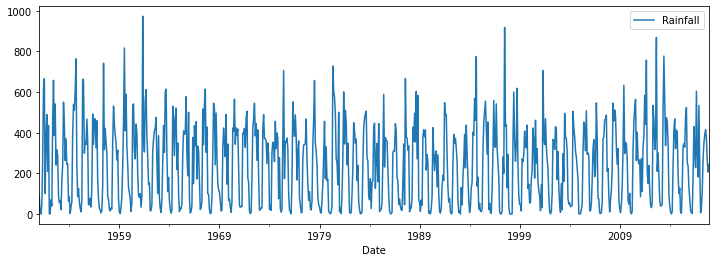

In [9]:
data.plot(figsize=(12,4))

### Detection of outliers

/home/rahul/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


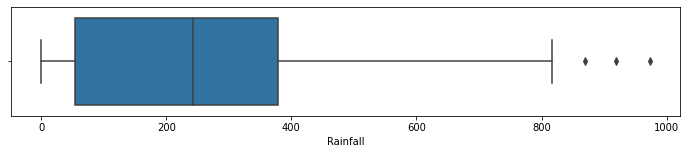

In [10]:
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(data['Rainfall'], whis=1.5)

As we can see there are three outliers we didn't remove them as it might signify some pattern in the time series

### Decomposition of Time series into trend,seasonal and residuals

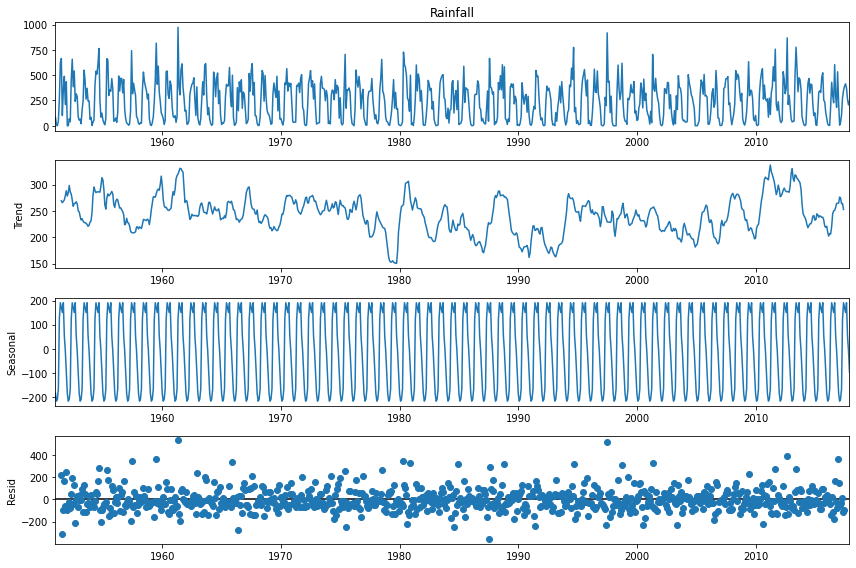

In [11]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data['Rainfall'], model='additive')
fig = decomposition.plot()
plt.show()

Observations : There is trend ,seasonality in the Data.As  we have taken monthly data there is seasonality (season wise rain) and we can see that residuals have constant mean and constant variance as there are some zero values in the data we can't do multiplicative decomposition

### Splitting the Data 

In [12]:
train_len = 644
train = data[0:train_len]
test = data[train_len:]

### Applied simple moving average for the Dataset

In [13]:
y_hat_sma = data.copy()
ma_window = 12

In [14]:
y_hat_sma['sma_forecast'] = data['Rainfall'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

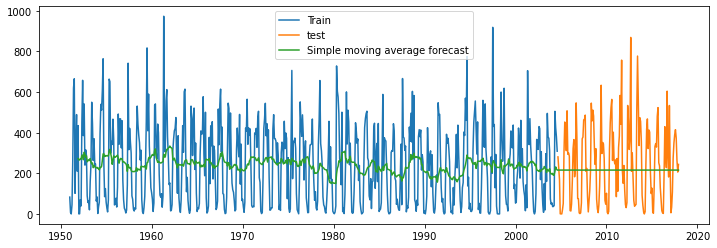

In [15]:
plt.figure(figsize=(12,4))
plt.plot(train['Rainfall'], label='Train')
plt.plot(test['Rainfall'], label='test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

As we can see it is almost straight line and not a good fit

### Exponential Smoothing Family

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
model = SimpleExpSmoothing(train['Rainfall'])
model_fit = model.fit(smoothing_level = 0.2, optimized=False)
model_fit.params

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 82.7,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [18]:
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(160)

In [19]:
rmse = np.sqrt(mean_squared_error(test['Rainfall'], y_hat_ses['ses_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  190.46


In [20]:
mape = round(np.mean(np.abs((test['Rainfall'] - y_hat_ses['ses_forecast'])/test['Rainfall'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  inf


In [21]:
results = pd.DataFrame({'Method':['Simple Exponential smoothing'], 'RMSE':[rmse], 'MAPE':[mape]})

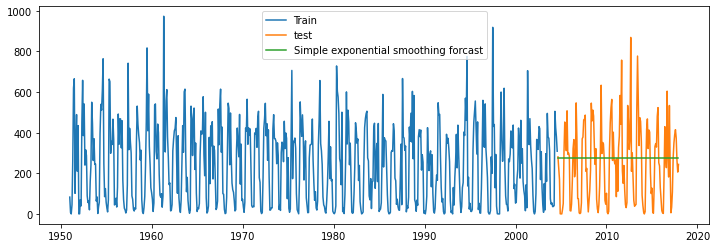

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Rainfall'], label='Train')
plt.plot(test['Rainfall'], label='test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

## Holts exponential smoothing

### Captures both Level and Trend

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [24]:
model = ExponentialSmoothing(np.asarray(train['Rainfall']), seasonal_periods = 12, trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.01, optimized=False)
model_fit.params

/tmp/ipykernel_380/1259488086.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.01, optimized=False)


{'smoothing_level': 0.2,
 'smoothing_trend': 0.01,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': -32.2533333333333,
 'initial_trend': 53.69515151515152,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [25]:
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(160)

In [26]:
rmse = np.sqrt(mean_squared_error(test['Rainfall'], y_hat_holt['holt_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  199.09


In [27]:
mape = round(np.mean(np.abs((test['Rainfall'] - y_hat_holt['holt_forecast'])/test['Rainfall'])*100),2)
print("mape for the above model is: ",mape)

mape for the above model is:  inf


In [28]:
results = results.append({'Method':'Holt\'s Winter smoothing method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_380/3729400153.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Holt\'s Winter smoothing method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


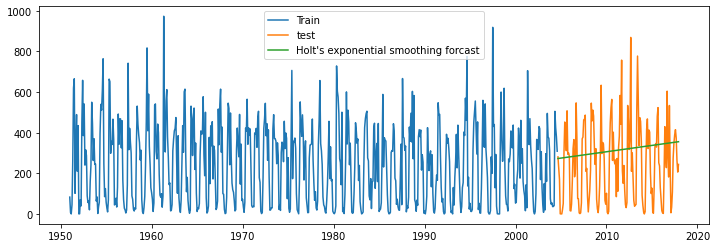

In [29]:
plt.figure(figsize=(12,4))
plt.plot(train['Rainfall'], label='Train')
plt.plot(test['Rainfall'], label='test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [30]:
y_hat_hwa = test.copy()

### Captures Seasonality also

In [31]:
model = ExponentialSmoothing(np.asarray(train['Rainfall']), seasonal_periods = 12, trend='additive', seasonal='additive')
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_hwa['hwa_forecast'] = model_fit.forecast(160)

In [32]:
rmse = np.sqrt(mean_squared_error(test['Rainfall'], y_hat_hwa['hwa_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  123.0


In [33]:
mape = round(np.mean(np.abs((test['Rainfall'] - y_hat_hwa['hwa_forecast'])/test['Rainfall'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  inf


In [34]:
results = results.append({'Method':'Holt\'s Winter additive method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_380/358243232.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Holt\'s Winter additive method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


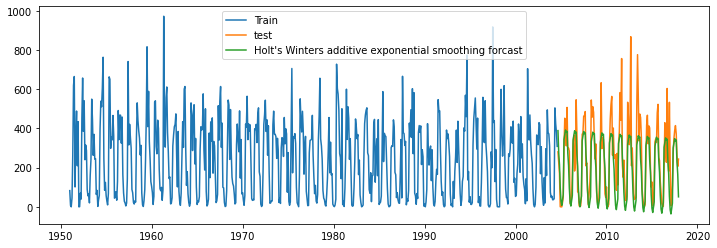

In [35]:
plt.figure(figsize=(12,4))
plt.plot(train['Rainfall'], label='Train')
plt.plot(test['Rainfall'], label='test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt\'s Winters additive exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

It gives much better fit than the other models and we have tried arima models

### Stationary Test

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
adf_test = adfuller(data['Rainfall'])
adf_test

(-6.495210578497677,
 1.1990436838899085e-08,
 18,
 785,
 {'1%': -3.438707722728768,
  '5%': -2.8652288644673125,
  '10%': -2.568734303622865},
 9719.043880219713)

As we can see it passes the stationary test statistic value is less than critical

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

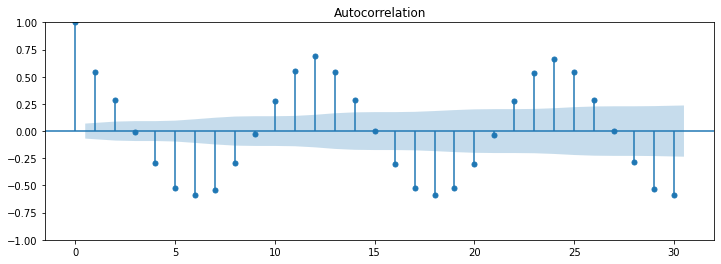

In [39]:
plt.figure(figsize=(12,4))
plot_acf(data, ax=plt.gca(), lags=30)
plt.show()

As we see in the graph there is seasonality still remains in the time series

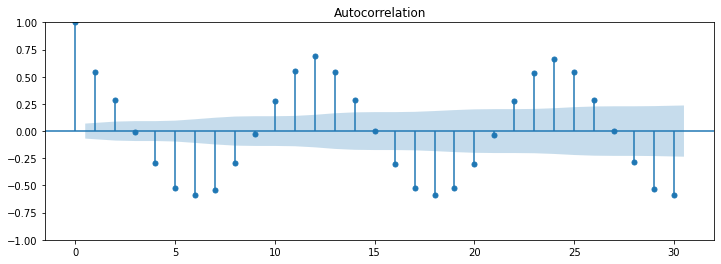

In [40]:
plt.figure(figsize=(12,4))
plot_acf(data, ax=plt.gca(), lags=30)
plt.show()

As we see in the graph there is seasonality still remains in the time series

So to remove seasonality we have applied seasonal differencing

In [41]:
data_1 = data.diff(periods=1, axis=0).diff(periods=12, axis=0).dropna()

### Plotting acf and pacf plots after seasonal differencing

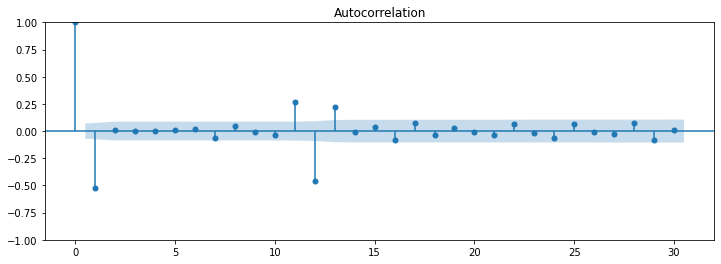

In [42]:
plt.figure(figsize=(12,4))
plot_acf(data_1, ax=plt.gca(), lags=30)
plt.show()

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


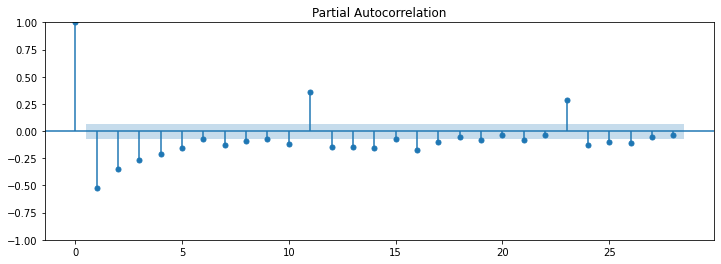

In [43]:
plt.figure(figsize=(12,4))
plot_pacf(data_1, ax=plt.gca(), lags=28)
plt.show()

It is much better than the previous data

### ARIMA MODEL

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
train = data_1[:633]
test = data_1[634:]

In [46]:
data_1.describe()

,Rainfall
count,791.000000
mean,-0.262073
std,215.064896
min,-954.500000
25%,-113.600000
50%,0.100000
75%,110.050000
max,942.700000


In [47]:
model = ARIMA(train, order=(5,1,1))

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
model_fit = model.fit()
model_fit.params
y_hat_ar = data_1.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_1.index.min(), data_1.index.max())

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [49]:
rmse = np.sqrt(mean_squared_error(data_1['Rainfall'], y_hat_ar['ar_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  168.73


In [50]:
mape = round(np.mean(np.abs((data_1['Rainfall'] - y_hat_ar['ar_forecast'])/data_1['Rainfall'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  364.27


In [51]:
results = results.append({'Method':'arima Model', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_380/3564558461.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'arima Model', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


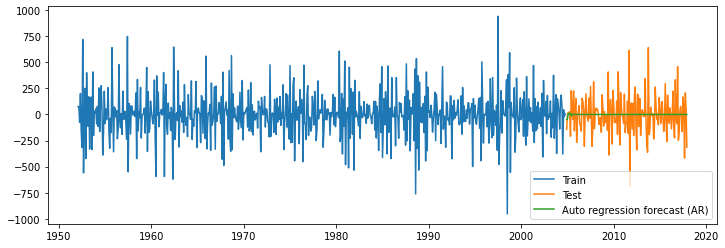

In [52]:
plt.figure(figsize=(12,4))
plt.plot(train['Rainfall'], label='Train')
plt.plot(test['Rainfall'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

As we see it gives less accuracy than exponential smoothing

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
model = SARIMAX(data_1, order=(5,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
y_hat_sarima = data_1.copy()
y_hat_sarima['sarima_forecast'] = model_fit.predict(data_1.index.min(), data_1.index.max())

/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rahul/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.32175D+00    |proj g|=  9.59082D-01


 This problem is unconstrained.



At iterate    5    f=  6.73645D+00    |proj g|=  1.46040D-02

At iterate   10    f=  6.72545D+00    |proj g|=  1.39106D-02

At iterate   15    f=  6.72066D+00    |proj g|=  4.42875D-03

At iterate   20    f=  6.53989D+00    |proj g|=  3.62673D-01

At iterate   25    f=  6.41876D+00    |proj g|=  5.21725D-02

At iterate   30    f=  6.40922D+00    |proj g|=  6.66601D-02

At iterate   35    f=  6.34819D+00    |proj g|=  1.36204D-01

At iterate   40    f=  6.31381D+00    |proj g|=  2.90076D-03

At iterate   45    f=  6.31376D+00    |proj g|=  8.71712D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     61   

In [55]:
rmse = np.sqrt(mean_squared_error(data_1['Rainfall'], y_hat_sarima['sarima_forecast'])).round(2)
print("Rmse for the above model is: ",rmse)

Rmse for the above model is:  165.0


In [56]:
mape = round(np.mean(np.abs((data_1['Rainfall'] - y_hat_sarima['sarima_forecast'])/data_1['Rainfall'])*100),2)
print("Mape for the above model is: ",mape)

Mape for the above model is:  435.54


In [57]:
results = results.append({'Method':'Sarima method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)

/tmp/ipykernel_380/1414972794.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Method':'Sarima method', 'RMSE':rmse, 'MAPE':mape}, ignore_index=True)


In [58]:
results

,Method,RMSE,MAPE
0,Simple Exponential smoothing,190.46,inf
1,Holt's Winter smoothing method,199.09,inf
2,Holt's Winter additive method,123.00,inf
3,arima Model,168.73,364.27
4,Sarima method,165.00,435.54


**Observations :** If we see the monthly rainfall data there is more seasonality than the annual rainfall data.Seasonality will disturb the stattionarity of the time series so arima model gave less accuracy we have got better accuracy with the holt winter additive method.By the analysis of monthly and annual rain fall data we observed whenever there is stationary time series arima model gave better accuracy and when it is not holt winter exponential method gave better accuracy